[View in Colaboratory](https://colab.research.google.com/github/silentvoice/dl-with-keras/blob/master/timeforecasting_using_rnns.ipynb)

## Check Tensorflow Version

In [0]:
#!kill -9 -1

In [0]:
import tensorflow as tf

In [5]:
tf.test.gpu_device_name()

'/device:GPU:0'

## Imports

In [0]:
from tensorflow import keras
from tensorflow.python.keras import models, layers
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import GRU, Embedding, Flatten, Dense
import numpy as np
import matplotlib.pyplot as plt
import os

## Data Loading

In [6]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

--2018-07-12 04:55:43--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.168.21
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.168.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  28.8MB/s    in 0.4s    

2018-07-12 04:55:44 (28.8 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13568290/13568290]



In [7]:
!unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  


In [0]:
data_dir = '/content/'

In [0]:
f_name = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(f_name)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

In [9]:
header

['"Date Time"',
 '"p (mbar)"',
 '"T (degC)"',
 '"Tpot (K)"',
 '"Tdew (degC)"',
 '"rh (%)"',
 '"VPmax (mbar)"',
 '"VPact (mbar)"',
 '"VPdef (mbar)"',
 '"sh (g/kg)"',
 '"H2OC (mmol/mol)"',
 '"rho (g/m**3)"',
 '"wv (m/s)"',
 '"max. wv (m/s)"',
 '"wd (deg)"']

In [10]:
len(lines)

420551

In [0]:
data = np.zeros((len(lines), len(header) - 1))

In [0]:
for idx, line in enumerate(lines):
  vals = [float(x) for x in line.split(',')[1:]]
  data[idx, :] = vals
  

In [13]:
data.shape

(420551, 14)

## Data Preparation

In [0]:
mean = data[:200000].mean(axis=0)
data -= mean
std = data[:200000].std(axis=0)
data /= std

In [0]:
def data_generator(data, lookback, delay, min_idx, max_idx, shuffle=False, batch_size=128, step=6):
  if max_idx is None:
    max_idx = len(data) - delay -1
  idx = min_idx + lookback
  while True:
    if shuffle:
      rows = np.random.randint(min_idx + lookback, max_idx, size=batch_size)
    else:
      if idx + batch_size >= max_idx:
        idx = min_idx + lookback
      rows = np.arange(idx, min(idx + batch_size, max_idx))
      idx += len(rows)
    samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
    targets = np.zeros((len(rows),))
    
    for i in range(len(rows)):
      indices = range(rows[i] - lookback, rows[i], step)
      samples[i] = data[indices]
      targets[i] = data[rows[i] + delay][1]
    yield samples, targets  
    

In [0]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

In [0]:
train_data_generator = data_generator(data,
                                      lookback=lookback,
                                      delay=delay,
                                      min_idx=0,
                                      max_idx=200000,
                                      shuffle=True,
                                      step=step, 
                                      batch_size=batch_size)
val_data_generator = data_generator(data,
                                    lookback=lookback,
                                    delay=delay,
                                    min_idx=200001,
                                    max_idx=300000,
                                    step=step,
                                    batch_size=batch_size)
test_data_generator = data_generator(data,
                                     lookback=lookback,
                                     delay=delay,
                                     min_idx=300001,
                                     max_idx=None,
                                     step=step,
                                     batch_size=batch_size)


In [0]:
val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(data) - 300001 - lookback) // batch_size

## Calculate Mean absolute Error to Determine base line

In [0]:
def evaluate_maes():
  batch_maes = []
  for _ in range(val_steps):
    samples, targets = next(val_data_generator)
    preds = samples[:, -1, 1]
    mae = np.mean(np.abs(preds - targets))
    batch_maes.append(mae)
  return np.mean(batch_maes)

In [20]:
evaluate_maes()

0.2897359729905486

In [21]:
np.mean(0.2897 * std[1])

2.5645689841146786

## Build Model

In [0]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, data.shape[-1])))
model.add(layers.Dense(1))

In [0]:
model.compile(optimizer='rmsprop', loss='mae')

In [25]:
model_history = model.fit_generator(train_data_generator,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_data_generator,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 381s 761ms/step - loss: 0.2985 - val_loss: 0.2690
Epoch 2/20
335/500 [===================>..........] - ETA: 1:27 - loss: 0.2878

500/500 [==============================] - 379s 759ms/step - loss: 0.2848 - val_loss: 0.2701
Epoch 3/20
500/500 [==============================] - 379s 757ms/step - loss: 0.2776 - val_loss: 0.2684
Epoch 4/20
 11/500 [..............................] - ETA: 4:18 - loss: 0.2801

500/500 [==============================] - 378s 755ms/step - loss: 0.2725 - val_loss: 0.2617
Epoch 5/20
392/500 [======================>.......] - ETA: 56s - loss: 0.2681

500/500 [==============================] - 379s 757ms/step - loss: 0.2673 - val_loss: 0.2669
Epoch 6/20
500/500 [==============================] - 378s 756ms/step - loss: 0.2637 - val_loss: 0.2650
Epoch 7/20
 26/500 [>.............................] - ETA: 4:07 - loss: 0.2548

500/500 [==============================] - 377s 755ms/step - loss: 0.2578 - val_loss: 0.2620
Epoch 8/20
398/500 [======================>.......] - ETA: 53s - loss: 0.2549

500/500 [==============================] - 377s 755ms/step - loss: 0.2545 - val_loss: 0.2651
Epoch 9/20
500/500 [==============================] - 379s 757ms/step - loss: 0.2503 - val_loss: 0.2695
Epoch 10/20
 27/500 [>.............................] - ETA: 4:10 - loss: 0.2548

500/500 [==============================] - 378s 756ms/step - loss: 0.2465 - val_loss: 0.2702
Epoch 11/20
396/500 [======================>.......] - ETA: 54s - loss: 0.2437

500/500 [==============================] - 377s 755ms/step - loss: 0.2429 - val_loss: 0.2713
Epoch 12/20
500/500 [==============================] - 378s 756ms/step - loss: 0.2390 - val_loss: 0.2840
Epoch 13/20
 24/500 [>.............................] - ETA: 4:10 - loss: 0.2398

500/500 [==============================] - 379s 757ms/step - loss: 0.2361 - val_loss: 0.2772
Epoch 14/20
395/500 [======================>.......] - ETA: 55s - loss: 0.2305

500/500 [==============================] - 377s 755ms/step - loss: 0.2306 - val_loss: 0.2884
Epoch 15/20
500/500 [==============================] - 372s 743ms/step - loss: 0.2285 - val_loss: 0.2861
Epoch 16/20
 24/500 [>.............................] - ETA: 4:10 - loss: 0.2305

500/500 [==============================] - 375s 750ms/step - loss: 0.2244 - val_loss: 0.2837
Epoch 17/20
395/500 [======================>.......] - ETA: 55s - loss: 0.2208

500/500 [==============================] - 375s 751ms/step - loss: 0.2210 - val_loss: 0.2890
Epoch 18/20
500/500 [==============================] - 375s 751ms/step - loss: 0.2173 - val_loss: 0.2942
Epoch 19/20
 24/500 [>.............................] - ETA: 4:10 - loss: 0.2165

500/500 [==============================] - 376s 751ms/step - loss: 0.2175 - val_loss: 0.3000
Epoch 20/20
395/500 [======================>.......] - ETA: 54s - loss: 0.2119

500/500 [==============================] - 376s 751ms/step - loss: 0.2123 - val_loss: 0.2945


## Plotting Loss

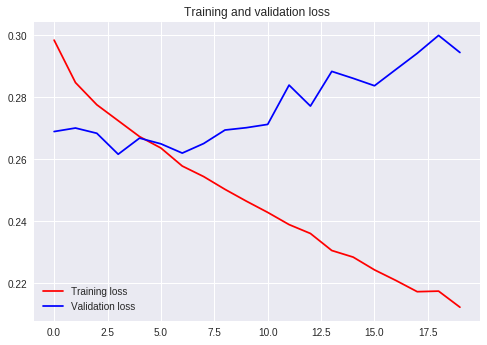

In [27]:
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(len(train_loss))

plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

## Increase the depth and regularize the network

In [0]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

In [0]:
model.compile(optimizer='rmsprop', loss='mae')

## Plotting Loss of Regularized Model

In [24]:
model_history = model.fit_generator(train_data_generator,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_data_generator,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 860s 2s/step - loss: 0.3364 - val_loss: 0.2853
Epoch 2/20
340/500 [===================>..........] - ETA: 3:10 - loss: 0.3135

500/500 [==============================] - 857s 2s/step - loss: 0.3121 - val_loss: 0.2811
Epoch 3/20
500/500 [==============================] - 857s 2s/step - loss: 0.3035 - val_loss: 0.2704
Epoch 4/20
 18/500 [>.............................] - ETA: 9:33 - loss: 0.3028

500/500 [==============================] - 857s 2s/step - loss: 0.3021 - val_loss: 0.2699
Epoch 5/20
402/500 [=======================>......] - ETA: 1:56 - loss: 0.2979

500/500 [==============================] - 857s 2s/step - loss: 0.2978 - val_loss: 0.2708
Epoch 6/20
500/500 [==============================] - 860s 2s/step - loss: 0.2959 - val_loss: 0.2699
Epoch 7/20
 33/500 [>.............................] - ETA: 9:14 - loss: 0.2904

500/500 [==============================] - 858s 2s/step - loss: 0.2933 - val_loss: 0.2681
Epoch 8/20
408/500 [=======================>......] - ETA: 1:49 - loss: 0.2906

500/500 [==============================] - 857s 2s/step - loss: 0.2905 - val_loss: 0.2775
Epoch 9/20
500/500 [==============================] - 859s 2s/step - loss: 0.2888 - val_loss: 0.2646
Epoch 10/20
 35/500 [=>............................] - ETA: 9:11 - loss: 0.2830

500/500 [==============================] - 858s 2s/step - loss: 0.2855 - val_loss: 0.2656
Epoch 11/20
406/500 [=======================>......] - ETA: 1:51 - loss: 0.2830

500/500 [==============================] - 856s 2s/step - loss: 0.2825 - val_loss: 0.2678
Epoch 12/20
500/500 [==============================] - 860s 2s/step - loss: 0.2817 - val_loss: 0.2685
Epoch 13/20
 32/500 [>.............................] - ETA: 9:16 - loss: 0.2810

500/500 [==============================] - 857s 2s/step - loss: 0.2818 - val_loss: 0.2659
Epoch 14/20
405/500 [=======================>......] - ETA: 1:52 - loss: 0.2779

500/500 [==============================] - 855s 2s/step - loss: 0.2779 - val_loss: 0.2736
Epoch 15/20
500/500 [==============================] - 854s 2s/step - loss: 0.2761 - val_loss: 0.2677
Epoch 16/20
 33/500 [>.............................] - ETA: 9:12 - loss: 0.2790

500/500 [==============================] - 856s 2s/step - loss: 0.2771 - val_loss: 0.2667
Epoch 17/20
405/500 [=======================>......] - ETA: 1:53 - loss: 0.2771

500/500 [==============================] - 859s 2s/step - loss: 0.2763 - val_loss: 0.2656
Epoch 18/20
500/500 [==============================] - 861s 2s/step - loss: 0.2759 - val_loss: 0.2652
Epoch 19/20
 32/500 [>.............................] - ETA: 9:19 - loss: 0.2706

500/500 [==============================] - 863s 2s/step - loss: 0.2734 - val_loss: 0.2732
Epoch 20/20
405/500 [=======================>......] - ETA: 1:53 - loss: 0.2726

500/500 [==============================] - 861s 2s/step - loss: 0.2727 - val_loss: 0.2682


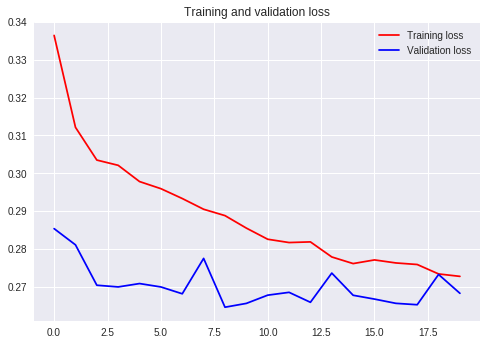

In [25]:
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(len(train_loss))

plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()